## **1. Data Preparation** 
### Importing Libraries


In [44]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import random

### **1.1 Data Preprocessing**

In [45]:
#Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Load MNIST datasets
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [46]:
# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print size
print("Size of training dataset:", len(train_dataset))
print("Size of testing dataset:", len(test_dataset))

# Print feature and target names
feature_names = [f'Pixel {i}' for i in range(28 * 28)]  # Each image is 28x28 pixels
print("Feature Names:", feature_names)

target_names = [str(i) for i in range(10)]  # Digits 0-9
print("Target Names:", target_names)

Size of training dataset: 60000
Size of testing dataset: 10000
Feature Names: ['Pixel 0', 'Pixel 1', 'Pixel 2', 'Pixel 3', 'Pixel 4', 'Pixel 5', 'Pixel 6', 'Pixel 7', 'Pixel 8', 'Pixel 9', 'Pixel 10', 'Pixel 11', 'Pixel 12', 'Pixel 13', 'Pixel 14', 'Pixel 15', 'Pixel 16', 'Pixel 17', 'Pixel 18', 'Pixel 19', 'Pixel 20', 'Pixel 21', 'Pixel 22', 'Pixel 23', 'Pixel 24', 'Pixel 25', 'Pixel 26', 'Pixel 27', 'Pixel 28', 'Pixel 29', 'Pixel 30', 'Pixel 31', 'Pixel 32', 'Pixel 33', 'Pixel 34', 'Pixel 35', 'Pixel 36', 'Pixel 37', 'Pixel 38', 'Pixel 39', 'Pixel 40', 'Pixel 41', 'Pixel 42', 'Pixel 43', 'Pixel 44', 'Pixel 45', 'Pixel 46', 'Pixel 47', 'Pixel 48', 'Pixel 49', 'Pixel 50', 'Pixel 51', 'Pixel 52', 'Pixel 53', 'Pixel 54', 'Pixel 55', 'Pixel 56', 'Pixel 57', 'Pixel 58', 'Pixel 59', 'Pixel 60', 'Pixel 61', 'Pixel 62', 'Pixel 63', 'Pixel 64', 'Pixel 65', 'Pixel 66', 'Pixel 67', 'Pixel 68', 'Pixel 69', 'Pixel 70', 'Pixel 71', 'Pixel 72', 'Pixel 73', 'Pixel 74', 'Pixel 75', 'Pixel 76', 'Pixel 

#### 1.1.1 Data Augmentation

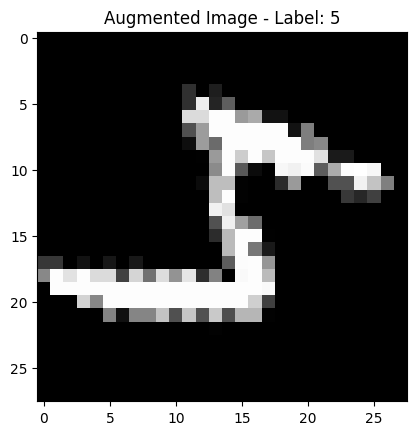

In [47]:
# Random rotation
augment_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

augmented_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=augment_transform)
# Visualize augmented images
image, label = augmented_dataset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Augmented Image - Label: {label}')
plt.show()


### **1.2 Data Analysis and Visulaization**

#### 1.2.1 Sample Images- Visualization

In [48]:
# plot samples with labels
def plot_samples(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

class_names = [str(i) for i in range(10)]
N = 1000  # Num of images for correlation

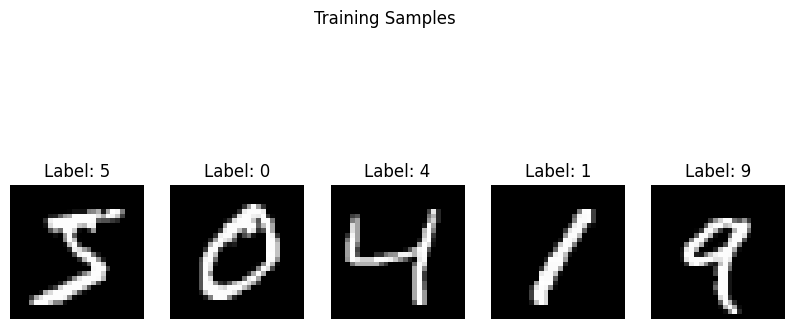

In [49]:
# Convert the first N images to a numpy array
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])
plot_samples(train_dataset.data.numpy()[:5], train_labels.numpy()[:5], class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

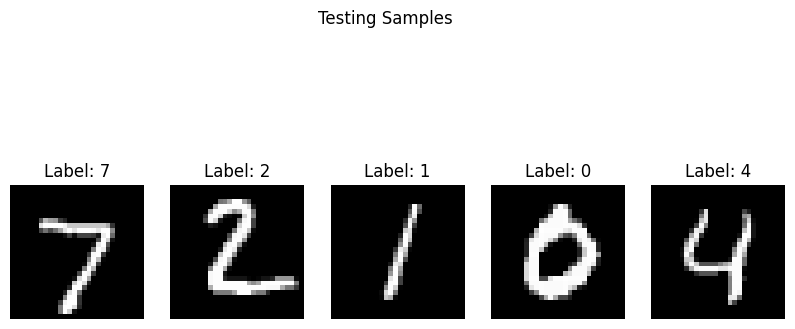

In [50]:
# Plot testing samples
test_images = torch.stack([test_dataset[i][0] for i in range(5)])
test_labels = torch.tensor([test_dataset[i][1] for i in range(5)])
plot_samples(test_images.numpy(), test_labels.numpy(), class_names, num_samples=5)
plt.suptitle('Testing Samples')
plt.show()#plot

#### 1.2.2 Mean and Standard Deviation

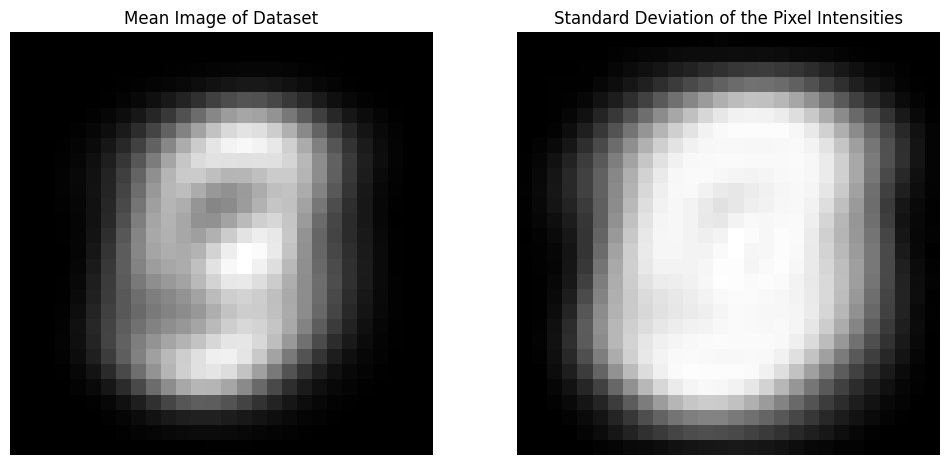

In [51]:
mean_image = torch.mean(train_dataset.data.float(), dim=0) # Mean of dataset
std_image = torch.std(train_dataset.data.float(), dim=0)  # Standard deviation of dataset

plt.figure(figsize=(12, 6))
# Mean image
plt.subplot(1, 2, 1)
plt.imshow(mean_image, cmap='gray')
plt.title("Mean Image of Dataset")
plt.axis('off')

# Standard deviation image
plt.subplot(1, 2, 2)
plt.imshow(std_image, cmap='gray')
plt.title("Standard Deviation of the Pixel Intensities")
plt.axis('off')

plt.show()

#### 1.2.3 Correlation Matrix of MNIST pixel values

/root/miniconda3/envs/my_pytorch/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/root/miniconda3/envs/my_pytorch/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


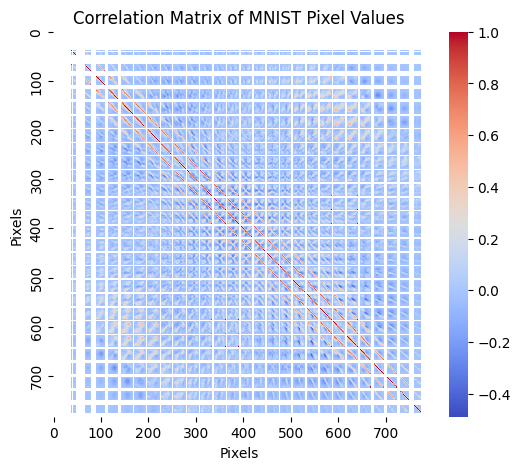

In [52]:
train_images = torch.stack([train_dataset[i][0] for i in range(N)])
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])
train_images = train_images.view(N, -1).numpy()

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(train_images.T)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, xticklabels=100, yticklabels=100)
plt.title('Correlation Matrix of MNIST Pixel Values')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

#### 1.2.4 Distribution of Digits

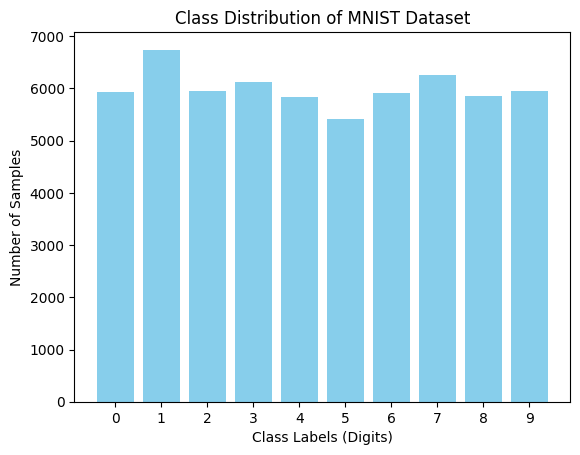

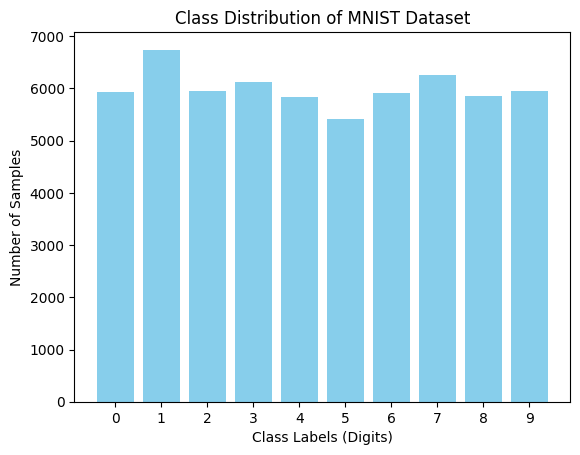

In [53]:
labels = train_dataset.targets

def plot_class_distribution(labels):
    unique, counts = np.unique(labels.numpy(), return_counts=True)

    # Create a bar plot for class distribution
    plt.bar(unique, counts, color='skyblue')
    plt.title('Class Distribution of MNIST Dataset')
    plt.xlabel('Class Labels (Digits)')
    plt.ylabel('Number of Samples')
    plt.xticks(unique)  # Set x-axis ticks to be the class labels
    plt.show()

plot_class_distribution(labels)
plot_class_distribution(labels)

In [54]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Image Shape: {train_dataset[0][0].shape}")

Total Training Samples: 60000
Total Testing Samples: 10000
Image Shape: torch.Size([1, 28, 28])


#### 1.2.5 Principal Component Analysis (PCA) on dataset

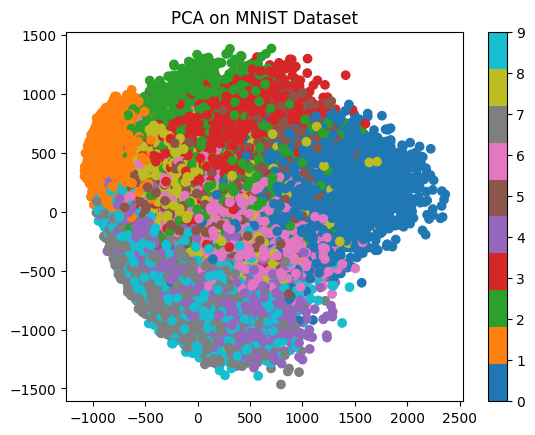

In [55]:
# Flatten the images for PCA
data = train_dataset.data.view(-1, 28*28).numpy()
labels = train_dataset.targets.numpy()

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('PCA on MNIST Dataset')
plt.show()

#### 1.3 Rotating selected images in the dataset to increase the diversity in data


In [61]:
random.seed(42) # create a fix random value

# Define transformations: rotations by different angles
rotate_right_15 = transforms.RandomRotation(degrees=(-15, -15))  # rotate by 15 degrees to right 
rotate_right_5 = transforms.RandomRotation(degrees=(-5, -5))  # rotate by 5 degrees to right 
rotate_left_15 = transforms.RandomRotation(degrees=(5, 5))     # rotate by 15 degrees to left 
rotate_left_5 = transforms.RandomRotation(degrees=(15, 15))     # rotate by 15 degrees to left 

to_tensor_transform = transforms.ToTensor()

# Function to divide, rotate, and replace 20% of images from each class
def rotate_and_replace(dataset, class_count, selected_portion):
    #create a dictionary to store the indices of data points belonging to each class
    #format will be like {0 :[],1:[]}
    class_indices = {}
    for i in range(class_count):
        class_indices[i] = []

    for img_index in range(len(dataset)):
        original_image, label = dataset[img_index]
        class_indices[label].append(img_index)


    
    # For each class, divide 20% of images into 4 parts and apply rotations
    for class_label, indices in class_indices.items():
        num_to_rotate = int(len(indices) * selected_portion)  # 20% of images from the class
        selected_indices = random.sample(indices, num_to_rotate)  # Randomly select the images to rotate
        
        #since we are going to rotate to left by 15 and 5 and rotatw tight to by 15 and 5 divide the dataset to 4 to avoid any duplicates
        quarter_size = num_to_rotate // 4  

        # Apply rotation to right by 15 degrees
        for index_r_15 in selected_indices[:quarter_size]:
            original_image, label = dataset[index_r_15]
            rotated_image = rotate_right_15(original_image)
            dataset.data[index_r_15] = (rotated_image * 255).byte()
        
        # Apply rotation to right by 5 degrees
        for index_r_5 in selected_indices[quarter_size:2 * quarter_size]:
            original_image, label = dataset[index_r_5]
            rotated_image = rotate_right_5(original_image)
            dataset.data[index_r_5] = (rotated_image * 255).byte()
        
        # Apply rotation to left by 15 degrees
        for index_l_15 in selected_indices[2 * quarter_size:3 * quarter_size]:
            original_image, label = dataset[index_l_15]
            rotated_image = rotate_left_15(original_image)
            dataset.data[index_l_15] = (rotated_image * 255).byte()
        
        # Apply rotation to left by 90 degrees
        for index_l_5 in selected_indices[3 * quarter_size:]:
            original_image, label = dataset[index_l_15]
            rotated_image = rotate_left_5(original_image)
            dataset.data[index_l_15] = (rotated_image * 255).byte() #convert to the range 0-255

    return dataset



#### 1.3.1 Apply for the training set

In [62]:
#percentage of rotation = 20%
train_dataset = rotate_and_replace(train_dataset, 10, 0.2)

#### 1.3.2 Test output after rotating

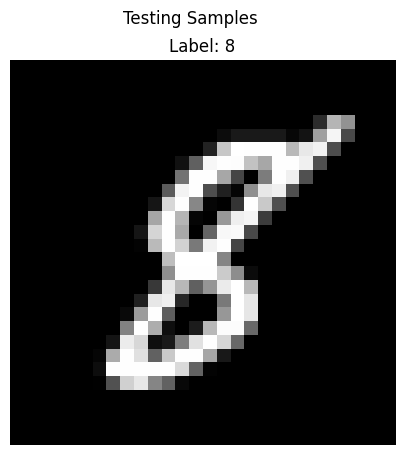

In [60]:
train_images = torch.stack([train_dataset[202][0]])
train_labels = torch.tensor([train_dataset[202][1]])
plot_samples(train_images.numpy(), train_labels.numpy(), class_names, num_samples=1)
plt.suptitle('Training Samples')
plt.show()#plot